Date: 2/19/2023 <br>
Author: Amparo Godoy Pastore

### Contents
    1. Introduction
    2. Preliminaries
    3. Gravitational Two-Body Problem
    4. Kepler's Laws of Orbital Motion
        4.1. First Law: Ellipses
        4.2. Second Law: Swept Area
        4.3. Third Law: Period
    5. Conclusion

# Introduction

In the early 17th century Kepler used detailed observations of the orbit of mars to propose three laws ruling the motion of planets around their star:
1. The orbits of planets are ellipses. The star occupies a focus of that ellipse.
2. The line joining the star and the planet sweeps area at a constant rate.
3. The square of the period of the orbit is proportional to the cube of its semi-major axis. <br>

In the late 17th century, Newton proposed his theory of mechanics and gravitation and showed it does predict all three of Kepler's laws. The objective of this notebook is to use scipy's numerical integration function, `solve_ivp`, to solve Newton's equations of orbital motion and verify Kepler's laws.

# Preliminaries
Here we import the necessary modules and define a function to create orbit animations.

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import vpython as vp
import itertools as itt
import math as m
from numpy.linalg import norm
from scipy.signal import find_peaks

# Checking/setting up vpython. The sphere may not show up, 
# but vpython should now be ready for when we actually need it.
vp.scene.delete()
vp.scene = vp.canvas(width=100,height=100)
vp.sphere()

# Function to animate 3D trajectories.
def animate(pos, rate=30, up=None, forward=None):
    '''
    pos:  Position of the objects as a function of time. NxMx3 array where 
        N=number of time steps, M=number of objects, and 3=number of spatial dimensions.
    rate: Frame rate. 
    '''
    pos = np.array(pos)
    vp.scene.delete()
    vp.scene = vp.canvas()
    if not up is None:
        vp.scene.up = up
    if not forward is None:
        vp.scene.forward = forward
    radius = 0.05
    # Draw cartesian basis.
    for i,color in zip(range(3),[vp.color.red,vp.color.green,vp.color.blue]):
        axis = 0.2*vp.vec(*np.roll([1,0,0],i))
        vp.arrow(pos=vp.vec(0,0,0), axis=axis, color=color)
    # Prepare to draw the objects.
    opt     = dict(radius=radius,make_trail=True,interval=1)
    spheres = []
    colors  = itt.cycle([vp.color.white, vp.color.red, vp.color.green, vp.color.blue])
    colors  = [next(colors) for i in range(pos.shape[1])]
    # Create spheres at initial positions.
    for j in range(pos.shape[1]):
        spheres.append(vp.sphere(pos=vp.vec(*pos[0,j]), color=colors[j], **opt))
    # Animate: move spheres to next position, wait for end of frame, rinse and repeat.
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            spheres[j].pos = vp.vec(*pos[i,j])
        vp.rate(rate)

# Test "animate".
T   = np.linspace(0,1.5,100)
pos = np.array([[[t,t,t-t**2],[-t,t,t-t**2],[t,-t,t-t**2],[-t,-t,t-t**2]] for t in T])
animate(pos, up=vp.vec(0,0,1), forward=vp.vec(1,0,-1))

<IPython.core.display.Javascript object>

# Gravitational Two-Body Problem
Take 2 objects interacting with each other via universal gravitation. The objects have mass $m_1$ and $m_2$, position vector $\vec{r_1}$ and $\vec{r_2}$, and velocities $\vec{v_1}$ and $\vec{v_2}$, respectively. The gravitational constant $G$ is set to $1$ for simplicity. 

In this section we integrate the following set of four vectorial first order ODEs using solve_ivp:

$$
\frac{d\vec{r_1}}{dt}=\vec{v_1} \\
\frac{d\vec{v_1}}{dt} = m_2\frac{\vec{r_2}-\vec{r_1}}{|\vec{r_2}-\vec{r_1}|^3} \\
\frac{d\vec{r_2}}{dt}=\vec{v_2} \\
\frac{d\vec{v_2}}{dt} = m_1\frac{\vec{r_1}-\vec{r_2}}{|\vec{r_1}-\vec{r_2}|^3}
$$

Once calculated, we plot the trajectory of each body in the xy plane and we create a 3d animation of the orbits.
 

<div class="alert alert-block alert-danger">
<b>Task 1</b>  
</div>

In [6]:
t0,t1,dt = 0,2e1,1e-1

# Masses and initial conditions.
r1,v1,m1 = np.array([0,0,0.]), np.array([0,0,0.]), 1.
r2,v2,m2 = np.array([1,0,0]), np.array([0,1.7,0]), 1.

# Switch to the frame of the center of mass.
r0 = (m1*r1+m2*r2)/(m1+m2) # Position of the center of mass.
v0 = (m1*v1+m2*v2)/(m1+m2) # Velocity of the center of mass.
r1,r2,v1,v2 = r1-r0,r2-r0,v1-v0,v2-v0

In [7]:
#concat into 1d array
x0 = np.concatenate([r1,v1,r2,v2])

#defining dxdt
def dxdt(t, x):
    r1,v1,r2,v2 = x[:3], x[3:6], x[6:9], x[9:13]
    dr1= v1
    dv1= m2*((r2-r1)/m.sqrt((r2-r1)[0]**2+(r2-r1)[1]**2+(r2-r1)[2]**2)**3) #* dt
    dr2 = v2
    dv2 = m1*((r1-r2)/m.sqrt((r1-r2)[0]**2+(r1-r2)[1]**2+(r1-r2)[2]**2)**3) #* dt
    return np.concatenate([dr1, dv1, dr2, dv2])

#integrate
T = np.linspace(t0, t1, int(t1/dt))
sol = solve_ivp(dxdt, [t0, t1], x0, t_eval = T, rtol=1e-6)

Below is the trajectory of the two bodies in the xy-plane.

(-1.4318311330696025,
 1.4318311330696025,
 -0.8874181751899314,
 0.8874181751899314)

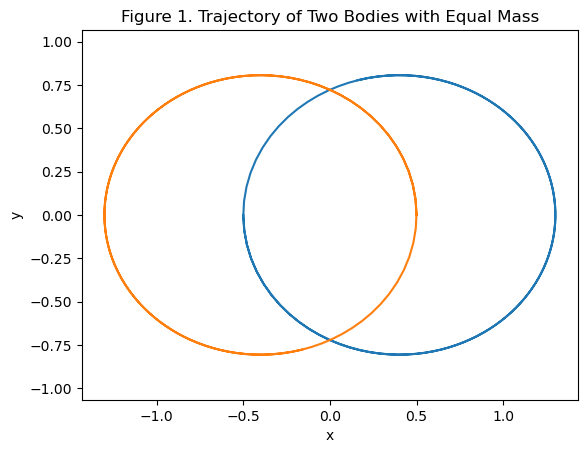

In [28]:
#plot
plt.plot(sol.y[0], sol.y[1])
plt.plot(sol.y[6], sol.y[7])
plt.title('Figure 1. Trajectory of Two Bodies with Equal Mass')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

And this is a 3D animation of the orbits.

In [10]:
#reorder R (2x3x200 -> 200x2x3) for animate
X = sol.y #retrieve solve_ivp results
R1,R2 = X[:3], X[6:9] #lists of positions
R = np.array([R1, R2])
animate(np.rollaxis(R, 2, 0))

<IPython.core.display.Javascript object>

# Kepler's Laws of Orbital Motion
Kepler's laws apply to systems where a heavy body is in gravitational interaction with a much lighter one. 

<div class="alert alert-block alert-danger">
<b>Task 2</b>
</div>

In [14]:
# Parameters and initial conditions.
t0,t1,dt = 0,50,1e-1
r1,v1,m1 = np.array([0,0,0.]), np.array([0,0,0.]), 1.
r2,v2,m2 = np.array([1,0,0]), np.array([0,1.2,0]), 1e-3

Here, we define a function that simulates a system of two masses in gravitational interaction, one of which is much heavier than the other. 

In [15]:
#Defining self contained function for task 1
def compute_orbits(r1, v1, r2, v2, m1, m2, t0, t1, dt):
    
    # Switch to the frame of the center of mass.
    r0 = (m1*r1+m2*r2)/(m1+m2) # Position of the center of mass.
    v0 = (m1*v1+m2*v2)/(m1+m2) # Velocity of the center of mass.
    r1,r2,v1,v2 = r1-r0,r2-r0,v1-v0,v2-v0
    
    #concat into 1d array
    x0 = np.concatenate([r1,v1,r2,v2])
    
    #defining dxdt
    def dxdt(t, x):
        r1,v1,r2,v2 = x[:3], x[3:6], x[6:9], x[9:]
        dr1= v1
        dv1= m2*((r2-r1)/m.sqrt((r2-r1)[0]**2+(r2-r1)[1]**2+(r2-r1)[2]**2)**3)
        dr2 = v2
        dv2 = m1*((r1-r2)/m.sqrt((r1-r2)[0]**2+(r1-r2)[1]**2+(r1-r2)[2]**2)**3)
        return np.concatenate([dr1, dv1, dr2, dv2])
    
    #integrate
    T = np.linspace(t0, t1, int(t1/dt))
    sol = solve_ivp(dxdt, [t0, t1], x0, t_eval = T, rtol=1e-6)
    
    #animate 200x2x3
    R1,V1,R2,V2 = sol.y[:3], sol.y[3:6], sol.y[6:9], sol.y[9:]
    
    return T, R1, V1, R2, V2

Now, we test the function `compute_orbits` and plot the result on the xy plane.

(-2.737502908875793,
 1.1769692829046932,
 -1.7592025818921642,
 1.7589821407439392)

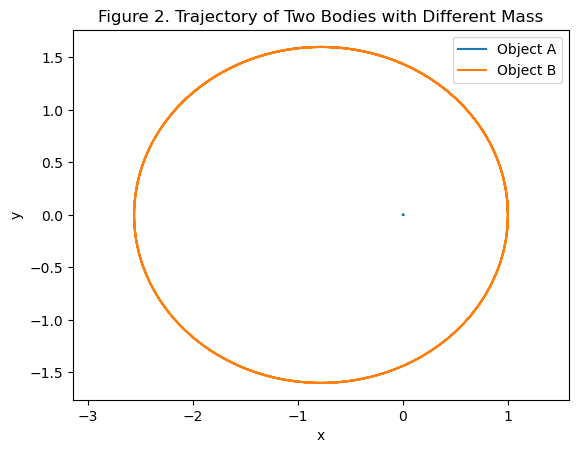

In [29]:
T, R1, V1, R2, V2 = compute_orbits(r1, v1, r2, v2, m1, m2, t0, t1, dt)
plt.plot(R1[0], R1[1], label = 'Object A')
plt.plot(R2[0], R2[1], label = 'Object B')
plt.legend()
plt.title('Figure 2. Trajectory of Two Bodies with Different Mass')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

As expected, _Figure 2_ shows object A, which is a thousand times heavier, hardly moves compared to object B.

## First Law: Ellipses
Kepler explains the polar equation of the orbit is that of an ellipse:

$r(\theta) = \dfrac{a(1-e^2)}{1+e\cos(\theta-\theta_0)}$

Now, we measure the semi-major axis $a$, the eccentricity $e$, and the polar angle of the periapsis $\theta_0$ from the trajectory in _Figure 2_. We then compute the x and y coordinates of the ellipse as $x=r(\theta)\cos\theta$ and $y=r(\theta)\sin\theta$. Lastly, we use these measurements to plot the ellipse and we superimpose the simulated trajectory from _Figure 2_.


<div class="alert alert-block alert-danger">
<b>Task 3</b>  
</div>

(-2.7397502875214887,
 1.178083347024833,
 -1.7607503451875122,
 1.7607503451875122)

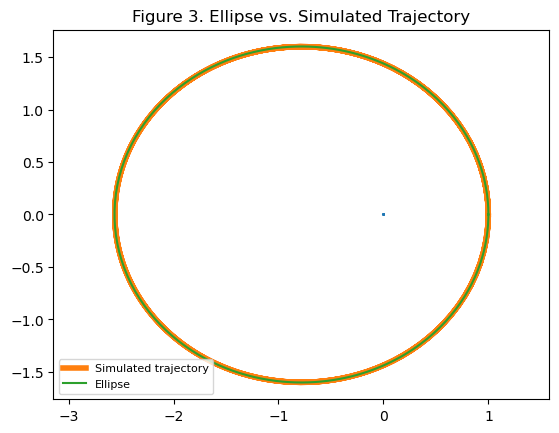

In [32]:
D = norm(R2 - R1, axis = 0) 
d_min, d_max = min(D), max(D)
a = (d_min + d_max)/2 #semi-major axis
e = (d_max - d_min) / (d_max + d_min) #eccentricity

#generate a series of values of theta 
theta = np.linspace(0, 2*np.pi, 200)

#get_r solves the ecuation of the ellipse given theta, a, and e
def get_r(theta, a, e):
    return a*(1-e**2) / (1+e*np.cos(theta))

#get list of x and y coordinates 
x = [get_r(th, a, e)*np.cos(th) for th in theta]
y = [get_r(th, a, e)*np.sin(th) for th in theta]

#plot
plt.plot(R1[0], R1[1])
plt.plot(R2[0], R2[1], lw=4, label = 'Simulated trajectory')
plt.plot(x, y, label = 'Ellipse')
plt.legend(loc = 'lower left', prop={'size':8})
plt.title('Figure 3. Ellipse vs. Simulated Trajectory')
plt.axis('equal')

_Figure 3_ shows the accuracy of both methods and verifies Kepler's first law, as the ellipse we just calculated (shown in green) and the simulated trajectory (shown in orange) overlap almost perfectly.

## Second Law: Swept Area
Kepler's second law states that the line joining the two objects sweeps a constant area per unit time. We assume that the area swept is the area of the triangle defined by object A and the two consecutive positions of object B, that is half the magnitude of the cross product of the vectors joining object A to each of the two positions of object B.

<div class="alert alert-block alert-warning" style="background-color:#f0ddcc; color:#663300">
<b>Extra Task 1</b>
</div>

(-2.49498997995992,
 52.394789579158314,
 0.05995488505945344,
 0.06006056216226014)

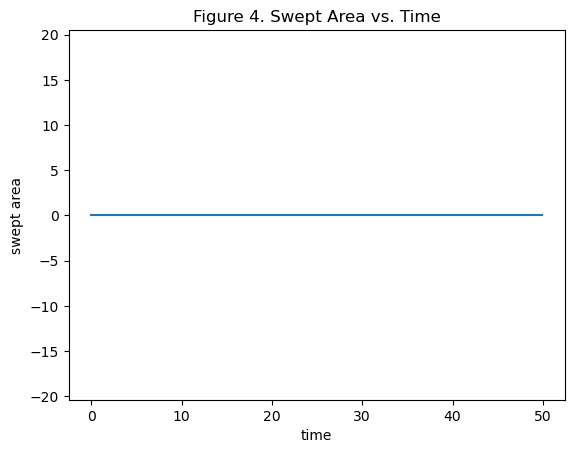

In [70]:
#rearranging the vectors of the two objects into 2 lists 
#because it wouldn't let me take the cross product
R1_ = [np.array((R1[0][i], R1[1][i], R1[2][i])) for i in range(len(R1[0]))]
R2_ = [np.array((R2[0][i], R2[1][i], R2[2][i])) for i in range(len(R2[0]))]


#calculating the area
areas = [1/2 * norm(np.cross(R1_[i] - R2_[i], R1_[i] - R2_[i+1])) for i in range(len(R2_)-1)]

#ploting as a function of time
plt.plot(T[:-1], area)
plt.xlabel('time')
plt.ylabel('swept area')
plt.title('Figure 4. Swept Area vs. Time')
plt.axis('equal')

The result is a flat line, shown in _Figure 4_, which verifies Kepler's second law. Due to the scale of the graph, it is difficult to see the oscilations in the value of the areas calculated so here are the first ten values:

In [72]:
print('First 10 areas: ', areas[:10])

First 10 areas:  [0.05996002788394614, 0.05996069438714115, 0.05996385953714785, 0.05996730307766587, 0.059971217884923905, 0.05997671388104861, 0.059981853258451734, 0.05998694297551077, 0.05999247307168748, 0.059997826601662696]


## Third Law: Period
Kepler's third law states that the square of the period of the orbit is proportional to the cube of its semi-major axis. To check this, we will simulate four orbits with different periods.

<div class="alert alert-block alert-danger">
<b>Task 4</b>  
</div>

First, we compute the period of the orbit from _Figure 3_. We have already computed $a$.

In [34]:
#look for the max points and find the corresponding times
time = [T[i] for i in range(len(D) - 1) if D[i] >= D[i-1] and D[i] >= D[i+1]]
#get period
period = time[1]-time[0]

#print results
print('The semi-major axis of the orbit is: ', a)
print('The period of the orbit is: ', period)
print('p^2/a^3 is: ', period**2/a**3)

The semi-major axis of the orbit is:  1.7811177814725279
The period of the orbit is:  14.929859719438877
p^2/a^3 is:  39.448776317403166


<div class="alert alert-block alert-danger">
<b>Task 5</b>  
</div>

Now we can simulate the four orbits using the following conditons:
- All four have `m1=1`, `m2=0.001`, `r1 = [0,0,0]`, `v1 = [0,0,0]`, `r2 = [1,0,0]`.
- `v2` is along $y$ with magnitude 0.5, 0.75, 1, and 1.25, respectively.



In [44]:
# Masses and initial conditions.
t0, t1, dt = 0,50,1e-1
r1,v1,m1 = np.array([0.,0.,0.]), np.array([0.,0.,0.]), 1.
r2,v2,m2 = np.array([1.,0.,0.]), np.array([0.,1.,0.]), .001
v2a,v2b,v2c,v2d = np.array([0,.5,0]), np.array([0,.75,0]), np.array([0,1,0]), np.array([0,1.25,0])

#simulating four orbits
orbit1 = list(compute_orbits(r1, v1, r2, v2a, m1, m2, t0, t1, dt))
orbit2 = list(compute_orbits(r1, v1, r2, v2b, m1, m2, t0, t1, dt))
orbit3 = list(compute_orbits(r1, v1, r2, v2c, m1, m2, t0, t1, dt))
orbit4 = list(compute_orbits(r1, v1, r2, v2d, m1, m2, t0, t1, dt))

In [61]:
#gets magnitude of R2 - R1
def get_D(orbit):
    return norm(orbit[3] - orbit[1], axis = 0)

#gets semi-major axis
def get_a(orbit):
    D = get_D(orbit)
    d_min, d_max = min(D), max(D)
    return (d_min + d_max)/2

A = [get_a(orbit1), get_a(orbit2), get_a(orbit3), get_a(orbit4)]

# gets periods
def get_p(orbit):
    peak,_ = find_peaks(get_D(orbit))
    return T[peak[1]] - T[peak[0]]

P = [get_p(orbit1), get_p(orbit2), get_p(orbit3), get_p(orbit4)]

As shown below, the square of the period divided by the cube of the semi_major axis of each orbit stays relatively constant. This verifies Kepler's third law that the period of the orbit is proportional to the cube of its semi-major axis.

In [60]:
#print results
print('Semi-major axis (a): ', A)
print('Periods (p): ', P)
print('p^2 / a^3: ', np.square(P)/[pow(i, 3) for i in A])

Semi-major axis (a):  [0.5713948718560846, 0.6955301102422183, 0.9988687036510852, 2.277624617279818]
Periods (p):  [2.705410821643287, 3.707414829659319, 6.212424849699399, 21.543086172344687]
p^2 / a^3:  [39.23353411 40.8502349  38.72550395 39.2798113 ]


Text(0, 0.5, 'Semi-major axis')

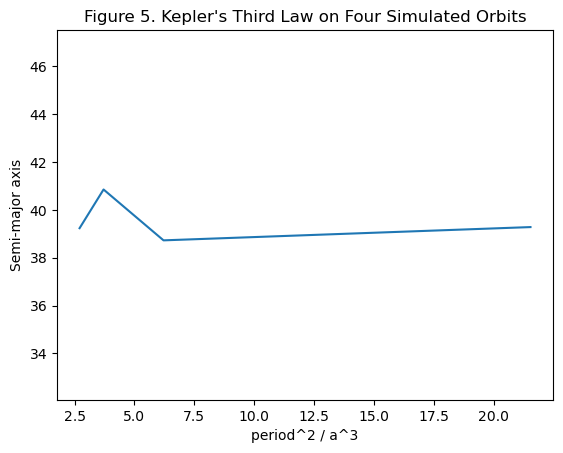

In [68]:
#Plot the square of the period divided by the cube of the semi-major axis against 
#the semi-major axis.
plt.plot(P, np.square(P)/[pow(i, 3) for i in A])
plt.axis('equal')
plt.title('Figure 5. Kepler\'s Third Law on Four Simulated Orbits')
plt.xlabel('period^2 / a^3')
plt.ylabel('Semi-major axis')

_Figure 5_ provides a visualization of the results already discussed.

# Conclusion

<div class="alert alert-block alert-danger">
<b>Writing Task</b> (here and everywhere)
</div>

In conclusion, the use of numerical integration through solve_ivp provided an effective means of solving Newton's equations of orbital motion. By applying this method, we were able to verify Kepler's three laws, which describe the motion of planets around their star.

The first law states that the orbit of each body is an ellipse. Our calculations demonstrated that the simulated orbits of the objects followed this pattern, indicating that the law holds true.

The second law states that a body sweeps out equal areas in equal times as it orbits around a much heavier body. Our calculations confirmed this law as well, as we observed that the area swept out by the object in each unit of time was consistent throughout their orbits.

Finally, the third law states that the square of an object's period is proportional to the cube of its semi-major axis. Through our calculations, we were able to verify this relationship, further reinforcing the validity of Kepler's laws.

Overall, through the application of scipy's `solve_ivp` numerical integration, we were able to verify the accuracy of these laws and deepen our understanding of the physics behind orbital motion.